# HDF Reference Recipe for CMIP6

This example illustrates how to create a {class}`pangeo_forge_recipes.recipes.HDFReferenceRecipe`.
This recipe does not actually copy the original source data.
Instead, it generates metadata files which reference and index the original data, allowing it to be accessed more efficiently.
For more background, see [this blog post](https://medium.com/pangeo/fake-it-until-you-make-it-reading-goes-netcdf4-data-on-aws-s3-as-zarr-for-rapid-data-access-61e33f8fe685).

As the input for this recipe, we will use some CMIP6 NetCDF4 files provided by ESGF and stored in Amazon S3 ([CMIP6 AWS Open Data Page](https://registry.opendata.aws/cmip6/)).
Many CMIP6 simulations spread their outputs over many HDF5/ NetCDF4 files, in order to limit the individual file size.
This can be inconvenient for analysis.
In this recipe, we will see how to virtually concatentate many HDF5 files into one big viritual Zarr dataset.

## Define the FilePattern

Let's pick a random dataset: ocean model output from the GFDL ocean model from the [OMIP](https://www.wcrp-climate.org/modelling-wgcm-mip-catalogue/cmip6-endorsed-mips-article/1063-modelling-cmip6-omip) experiments.

In [1]:
import s3fs
fs = s3fs.S3FileSystem(anon=True)
base_path = 's3://esgf-world/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/Omon/thetao/gr/v20180701/'
all_paths = fs.ls(base_path)
all_paths

['esgf-world/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/Omon/thetao/gr/v20180701/thetao_Omon_GFDL-CM4_omip1_r1i1p1f1_gr_170801-172712.nc',
 'esgf-world/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/Omon/thetao/gr/v20180701/thetao_Omon_GFDL-CM4_omip1_r1i1p1f1_gr_172801-174712.nc',
 'esgf-world/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/Omon/thetao/gr/v20180701/thetao_Omon_GFDL-CM4_omip1_r1i1p1f1_gr_174801-176712.nc',
 'esgf-world/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/Omon/thetao/gr/v20180701/thetao_Omon_GFDL-CM4_omip1_r1i1p1f1_gr_176801-178712.nc',
 'esgf-world/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/Omon/thetao/gr/v20180701/thetao_Omon_GFDL-CM4_omip1_r1i1p1f1_gr_178801-180712.nc',
 'esgf-world/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/Omon/thetao/gr/v20180701/thetao_Omon_GFDL-CM4_omip1_r1i1p1f1_gr_180801-182712.nc',
 'esgf-world/CMIP6/OMIP/NOAA-GFDL/GFDL-CM4/omip1/r1i1p1f1/Omon/thetao/gr/v20180701/thetao_Omon_GFDL-CM4_omip1_r1i1p1f1_gr_182801-184712.nc',
 'esgf-world/

We see there are 15 individual NetCDF files. Let's time how long it takes to open and display one of them using Xarray.

```{note}
The argument `decode_coords='all'` helps Xarray promote all of the `_bnds` variables to coordinates (rather than data variables).
```

In [2]:
import xarray as xr

In [3]:
%%time
ds_orig = xr.open_dataset(fs.open(all_paths[0]), engine='h5netcdf', chunks={}, decode_coords='all')
ds_orig

<timed exec>:1: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacello', 'volcello']


CPU times: user 613 ms, sys: 154 ms, total: 767 ms
Wall time: 5.32 s


<xarray.Dataset>
Dimensions:    (lat: 180, bnds: 2, lon: 360, time: 240, lev: 35)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time       (time) object 1708-01-16 12:00:00 ... 1727-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(240, 2), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
Dimensions without coordinates: bnds
Data variables:
    thetao     (time, lev, lat, lon) float32 dask.array<chunksize=(240, 35, 180, 360), meta=np.ndarray>
Attributes: (12/44)
    title:                 NOAA GFDL GFDL-CM4 model output prepared for CMIP6...
    history:               File was processed by fremetar (GFDL analog of CMO...
    external_variables:    areacello volcello
    table_id:              Omon
    activity_id:           OMIP
    branch_method:         none provided
    ...                    ...
    sub_experiment_id:     none
    tracking_id:           hdl:21.14100/97e4edf3-22e7-4e5f-831a-f2a671b7094f
    variable_id:           thetao
    variant_info:          N/A
    references:            see further_info_url attribute
    variant_label:         r1i1p1f1

It took ~30 seconds to open this one dataset. So it would take 7-8 minutes for us to open every file. This would be annoyingly slow.

As a first step in our recipe, we create a `File Pattern <../../recipe_user_guide/file_patterns>` to represent the input files.
In this case, since we already have a list of inputs, we just use the `pattern_from_file_sequence` convenience function.

In [4]:
from pangeo_forge_recipes.patterns import pattern_from_file_sequence
pattern = pattern_from_file_sequence(['s3://' + path for path in all_paths], 'time')
pattern

<FilePattern {'time': 15}>

## Define the Recipe

Once we have our `FilePattern` defined, defining our Recipe is straightforward.
The only custom options we need are to specify that we'll be accessing the source files anonymously and to use `decode_coords='all'` when opening them.

In [5]:
from pangeo_forge_recipes.recipes.reference_zarr import HDFReferenceRecipe

rec = HDFReferenceRecipe(
    pattern,
    # xarray_open_kwargs={"decode_coords": "all"},
    netcdf_storage_options={"anon": True}
)
rec

HDFReferenceRecipe(file_pattern=<FilePattern {'time': 15}>, storage_config=StorageConfig(target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7ff638ac8b20>, root_path='/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmp4il24viw/Cfp7V9KL'), cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7ff638ac8b20>, root_path='/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmp4il24viw/TzoUPkEa'), metadata=MetadataTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7ff638ac8b20>, root_path='/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmp4il24viw/xKhoLFFJ')), output_json_fname='reference.json', output_intake_yaml_fname='reference.yaml', netcdf_storage_options={'anon': True}, inline_threshold=500, output_storage_options={}, concat_dims=[], identical_dims=[], coo_map={}, coo_dtypes={}, preprocess=None, postprocess=None)

## Storage

If the recipe excecution occurs in a Bakery, cloud storage will be assigned automatically.

For this example, we use the recipe's default storage, which is a temporary local directory.

## Execute with Dask

This runs relatively slowly in serial on a small laptop, but it would scale out very well on the cloud.

In [6]:
from dask.diagnostics import ProgressBar
delayed = rec.to_dask()
with ProgressBar():
    delayed.compute()

[########################################] | 100% Completed |  9min  1.7s


## Examine the Result

### Load with Intake

The easiest way to load the dataset created by `fsspec_reference_maker` is via intake.
An intake catalog is automatically created in the target.

In [7]:
cat_url = f"{rec.target}/reference.yaml"
cat_url

'file:///var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmp4il24viw/Cfp7V9KL/reference.yaml'

In [8]:
import intake
cat = intake.open_catalog(cat_url)
cat

reference:
  args:
    path: file:///var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmp4il24viw/Cfp7V9KL/reference.yaml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


To load the data lazily:

In [9]:
%time ds = cat.data.to_dask()
ds

CPU times: user 175 ms, sys: 12.1 ms, total: 187 ms
Wall time: 733 ms


<xarray.Dataset>
Dimensions:    (lat: 180, time: 3600, bnds: 2, lev: 35, lon: 360)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 1708-01-16 12:00:00 ... 2007-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(1, 35, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    thetao     (time, lev, lat, lon) float32 dask.array<chunksize=(1, 18, 90, 180), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/44)
    Conventions:           CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:           OMIP
    branch_method:         none provided
    branch_time_in_child:  0.0
    comment:               Experiment name = OM4p25_IAF_BLING_csf_rerun\nFor ...
    contact:               gfdl.climate.model.info@noaa.gov
    ...                    ...
    table_id:              Omon
    title:                 NOAA GFDL GFDL-CM4 model output prepared for CMIP6...
    tracking_id:           hdl:21.14100/97e4edf3-22e7-4e5f-831a-f2a671b7094f
    variable_id:           thetao
    variant_info:          N/A
    variant_label:         r1i1p1f1

Note that it opened immediately! 🎉

```{note}
The Zarr chunks of the reference dataset correspond 1:1 to the HDF5 chunks in the original dataset.
These chunks are often smaller than optimal for cloud-based analysis.
```

If we want to pass custom options to xarray when loading the dataset, we do so as follows.
In this example, we specify larger chunks and fix the coords.

In [10]:
ds = cat.data(
    chunks={'time': 10, 'lev': -1, 'lat': -1, 'lon': -1},
    decode_coords='all'
).to_dask()
ds

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/intake_xarray/xzarr.py:46: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacello', 'volcello']
  self._ds = xr.open_dataset(self.urlpath, **kw)


<xarray.Dataset>
Dimensions:    (lat: 180, time: 3600, bnds: 2, lev: 35, lon: 360)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(10, 180, 2), meta=np.ndarray>
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(10, 35, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(10, 360, 2), meta=np.ndarray>
  * time       (time) object 1708-01-16 12:00:00 ... 2007-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    thetao     (time, lev, lat, lon) float32 dask.array<chunksize=(10, 35, 180, 360), meta=np.ndarray>
Attributes: (12/44)
    Conventions:           CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:           OMIP
    branch_method:         none provided
    branch_time_in_child:  0.0
    comment:               Experiment name = OM4p25_IAF_BLING_csf_rerun\nFor ...
    contact:               gfdl.climate.model.info@noaa.gov
    ...                    ...
    table_id:              Omon
    title:                 NOAA GFDL GFDL-CM4 model output prepared for CMIP6...
    tracking_id:           hdl:21.14100/97e4edf3-22e7-4e5f-831a-f2a671b7094f
    variable_id:           thetao
    variant_info:          N/A
    variant_label:         r1i1p1f1

### Manual Loading

It is also possible to load the reference dataset directly with xarray, bypassing intake.

In [11]:
ref_url = f"{rec.target}/reference.json"
ref_url

'file:///var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmp4il24viw/Cfp7V9KL/reference.json'

In [12]:
import fsspec
m = fsspec.get_mapper(
    "reference://",
    fo=ref_url,
    target_protocol="file",
    remote_protocol="s3",
    remote_options=dict(anon=True),
    skip_instance_cache=True,
)
ds = xr.open_dataset(
    m,
    engine='zarr',
    backend_kwargs={'consolidated': False},
    chunks={},
    decode_coords="all"
)
ds

/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/ipykernel_32099/1005713631.py:10: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacello', 'volcello']
  ds = xr.open_dataset(


<xarray.Dataset>
Dimensions:    (lat: 180, time: 3600, bnds: 2, lev: 35, lon: 360)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(1, 180, 2), meta=np.ndarray>
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(1, 35, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
  * time       (time) object 1708-01-16 12:00:00 ... 2007-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    thetao     (time, lev, lat, lon) float32 dask.array<chunksize=(1, 18, 90, 180), meta=np.ndarray>
Attributes: (12/44)
    Conventions:           CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:           OMIP
    branch_method:         none provided
    branch_time_in_child:  0.0
    comment:               Experiment name = OM4p25_IAF_BLING_csf_rerun\nFor ...
    contact:               gfdl.climate.model.info@noaa.gov
    ...                    ...
    table_id:              Omon
    title:                 NOAA GFDL GFDL-CM4 model output prepared for CMIP6...
    tracking_id:           hdl:21.14100/97e4edf3-22e7-4e5f-831a-f2a671b7094f
    variable_id:           thetao
    variant_info:          N/A
    variant_label:         r1i1p1f1

### Make a Map

Let's just verify that we can read an visualize the data. We'll compare the first year to the last year.

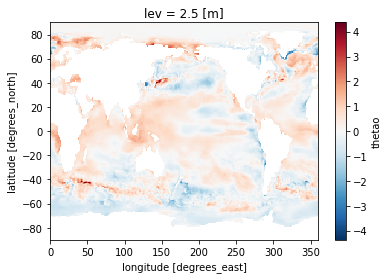

In [13]:
ds_ann = ds.resample(time='A').mean()
sst_diff = ds_ann.thetao.isel(time=-1, lev=0) - ds_ann.thetao.isel(time=0, lev=0)
sst_diff.plot()